In [19]:
import warnings
warnings.filterwarnings("ignore")
!pip install -q monai

In [20]:
#Libraries from Demo
import os
import shutil
from collections import defaultdict

import pandas as pd
import polars as pl
import pydicom as dicom


#Libraries from attempt
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.ndimage as ndi
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter
from scipy import ndimage

from scipy.ndimage import zoom as ndi_zoom
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader, Subset
from typing import Tuple, List
from monai.losses import DiceLoss

from sklearn.preprocessing import StandardScaler

In [21]:
def seed_everything(seed=42):
    """
    Set random seeds for reproducibility in deep learning projects.
    
    Args:
        seed (int): Random seed value (default: 42)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything()

In [22]:
ID_COL = 'SeriesInstanceUID'
LABEL_COLS = [
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
    'Aneurysm Present',
]

NUM_LABELS = len(LABEL_COLS) 

In [23]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_CSV = "/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv"
test_frac = 0.2
val_frac = 0.1
val_frac_within_trainval = val_frac / (1 - test_frac)
seed = 42  

In [24]:
train = pd.read_csv(TRAIN_CSV)
print(f"On the original Dataset, the percentage of aneurysms is: {100 * sum(train['Aneurysm Present'])/len(train)}%")
print(f"The original dataset has {len(train)} samples.")

On the original Dataset, the percentage of aneurysms is: 42.84728610855566%
The original dataset has 4348 samples.


In [25]:
excluded = np.load('/kaggle/input/succesful/usefull.npz')["lst"]
print(len(excluded))
train = train[train['SeriesInstanceUID'].isin(excluded)]

3984


In [26]:
y = train["Aneurysm Present"].astype(int).values
sss = StratifiedShuffleSplit(n_splits=1, test_size=test_frac, random_state=seed)
(trainval_idx, test_idx), = sss.split(np.zeros(len(y)), y)
y_trainval = y[trainval_idx]

sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=val_frac_within_trainval, random_state=seed)
(train_rel_idx, val_rel_idx), = sss_2.split(np.zeros(len(y_trainval)), y_trainval)
train_idx = trainval_idx[train_rel_idx]
val_idx   = trainval_idx[val_rel_idx]

train_ds = Subset(train, train_idx.tolist())
val_ds   = Subset(train, val_idx.tolist())
test_ds  = Subset(train, test_idx.tolist())

print(f"Train/Val/Test sizes: {len(train_ds)} / {len(val_ds)} / {len(test_ds)}")
print(len(train.iloc[train_idx]), len(train.iloc[val_idx]), len(train.iloc[test_idx]))
print("Train positive rate:", train.iloc[train_idx]["Aneurysm Present"].mean())
print("Val   positive rate:", train.iloc[val_idx]["Aneurysm Present"].mean())
print("Test   positive rate:", train.iloc[test_idx]["Aneurysm Present"].mean())

Train/Val/Test sizes: 2788 / 399 / 797
2788 399 797
Train positive rate: 0.37625538020086086
Val   positive rate: 0.37593984962406013
Test   positive rate: 0.37641154328732745


# Datasets

In [27]:
from torch.utils.data import Dataset
from pathlib import Path
import os, numpy as np, torch

from torch.utils.data import Dataset
import os, numpy as np, torch

class CachedVolumeDataset(Dataset):
    def __init__(self, df, vols_dirs, mask_dirs, id_col, transform=None):
        self.df = df.reset_index(drop=True).copy()
        self.vols_dirs = list(vols_dirs)
        self.mask_dirs = list(mask_dirs)
        self.id_col = id_col
        self.transform = transform

        assert len(self.vols_dirs) == len(self.mask_dirs), \
            "Volume and mask directory lists must be the same length"

    def __len__(self):
        return len(self.df)

    def _find_files(self, sid):
        fname = f"{sid}.npz"

        # Iterate over (vol_dir, mask_dir) pairs
        for vol_dir, mask_dir in zip(self.vols_dirs, self.mask_dirs):

            vol_path  = os.path.join(vol_dir,  fname)
            mask_path = os.path.join(mask_dir, fname)

            if os.path.exists(vol_path) and os.path.exists(mask_path):
                return vol_path, mask_path

        return None

    def __getitem__(self, idx):
        sid = str(self.df[self.id_col].iloc[idx])

        paths = self._find_files(sid)
        vol_path, mask_path = paths

        # Load files
        vol  = np.load(vol_path)["vol"].astype(np.float32)      # [D, H, W]
        mask = np.load(mask_path)["vol"].astype(np.float32)    # [D, H, W]

        # Convert to PyTorch tensors with channel dimension
        x = torch.from_numpy(vol).unsqueeze(0)    # [1, D, H, W]
        y = torch.from_numpy(mask).unsqueeze(0)   # [1, D, H, W]

        if self.transform:
            x, y = self.transform(x, y)

        return x, y

    def verify(self):
        missing = []
        for sid in self.df[self.id_col].astype(str):
            if self._find_files(sid) is None:
                missing.append(sid)
        return missing


In [28]:
PROCESSED_DATA_DIRS_MASKS = [
    "/kaggle/input/binary-masks-dataset/masks_quart1_2_5",
    "/kaggle/input/binary-masks-dataset/masks_quart2_2_5",
    "/kaggle/input/binary-masks-dataset/masks_quart3_2_5",
    "/kaggle/input/binary-masks-dataset/masks_quart4_2_5",
]

PROCESSED_DATA_DIRS_VOLS = [
    "/kaggle/input/vol-dataset-1-25-iso/vols_quart1 (1)",
    "/kaggle/input/vol-dataset-1-25-iso/vols_quart2 (1)",
    "/kaggle/input/vol-dataset-1-25-iso/vols_quart3 (1)",
    "/kaggle/input/vol-dataset-1-25-iso/vols_quart4 (1)",
]

train_ds = CachedVolumeDataset(
    df=train.iloc[train_idx],
    vols_dirs=PROCESSED_DATA_DIRS_VOLS,
    mask_dirs=PROCESSED_DATA_DIRS_MASKS,
    id_col=ID_COL
)

valid_ds = CachedVolumeDataset(
    df=train.iloc[val_idx],
    vols_dirs=PROCESSED_DATA_DIRS_VOLS,
    mask_dirs=PROCESSED_DATA_DIRS_MASKS,
    id_col=ID_COL
)

test_ds = CachedVolumeDataset(
    df=train.iloc[test_idx],
    vols_dirs=PROCESSED_DATA_DIRS_VOLS,
    mask_dirs=PROCESSED_DATA_DIRS_MASKS,
    id_col=ID_COL
)
print(len(train_ds), len(valid_ds), len(test_ds))

2788 399 797


# Reviewing X=volume, Y=mask to test Loader

Volume: torch.Size([1, 160, 160, 160])
Mask: torch.Size([1, 160, 160, 160])
Slices containing mask pixels: tensor([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])
Number of slices with mask: 48


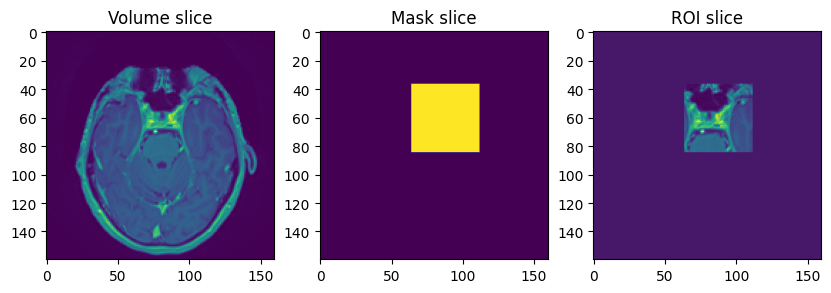

In [29]:
x, y = train_ds[95]
print("Volume:", x.shape)
print("Mask:", y.shape)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(x[0, 57].numpy())
plt.title("Volume slice")

plt.subplot(1,3,2)
plt.imshow(y[0, 57].numpy())
plt.title("Mask slice")

plt.subplot(1,3,3)
plt.imshow(x[0, 57].numpy() *  y[0, 57].numpy())
plt.title("ROI slice")

# Find all slices with mask pixels
# y shape = [C, D, H, W]
# Step 1: Max over H and W
mask_2d_max = y.max(dim=3)[0].max(dim=2)[0]   # shape: [1, D]
mask_1d = mask_2d_max.squeeze(0)  # shape: [D]

# Step 3: Get indices of slices containing mask
mask_slices = (mask_1d == 1).nonzero(as_tuple=True)[0]

print("Slices containing mask pixels:", mask_slices)
print("Number of slices with mask:", len(mask_slices))

# Model

In [30]:
class ConvBlock3D(nn.Module):
    """
    3D convolutional downsampling block:
    Based on: 
    github.com/ahsan-83/Deep-Learning-Specialization-Coursera/blob/main/Convolutional%20Neural%20Networks/Assignment/Week%203-Programming%20Assignment%20Image%20Segmentation%20with%20U-Net/Image_segmentation_Unet_v2.ipynb
    Tweaked for 3D
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
      next_layer, skip_connection --  Next layer and skip connection outputs
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.0, use_maxpool=True):
        super().__init__()
        self.use_maxpool = use_maxpool

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.dropout = nn.Dropout3d(dropout_prob) if dropout_prob > 0 else None
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2) if use_maxpool else None

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)

        if self.dropout is not None:
            x = self.dropout(x)
            
        if self.use_maxpool:
            next_layer = self.pool(x)
        else:
            next_layer = x

        skip = x  # skip connection

        return next_layer, skip


In [31]:
class UpBlock3D(nn.Module):
    """
    Convolutional upsampling block
    Based on: 
    github.com/ahsan-83/Deep-Learning-Specialization-Coursera/blob/main/Convolutional%20Neural%20Networks/Assignment/Week%203-Programming%20Assignment%20Image%20Segmentation%20with%20U-Net/Image_segmentation_Unet_v2.ipynb
    Tweaked for 3D
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # upsample by factor 2 in D, H, W
        self.upconv = nn.ConvTranspose3d(
            in_channels, out_channels,
            kernel_size=2, stride=2
        )

        # Merge the previous output and the contractive_input
        self.conv1 = nn.Conv3d(out_channels * 2, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, expansive_input, contractive_input):
        x = self.upconv(expansive_input)
        x = torch.cat([contractive_input, x], dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)

        return x

In [32]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, n_filters=16, n_classes=1):
        """
        in_channels: channels of input volume (e.g., 1 for CT/MRI)
        n_filters: base number of filters (you may want 16 or 32 depending on GPU)
        n_classes: output channels (1 for binary mask)
        """
        super().__init__()

        # Encoder: Down
        self.enc1 = ConvBlock3D(in_channels,      n_filters,      dropout_prob=0.0, use_maxpool=True)
        self.enc2 = ConvBlock3D(n_filters,        n_filters * 2,  dropout_prob=0.0, use_maxpool=True)
        self.enc3 = ConvBlock3D(n_filters * 2,    n_filters * 4,  dropout_prob=0.0, use_maxpool=True)
        self.enc4 = ConvBlock3D(n_filters * 4,    n_filters * 8,  dropout_prob=0.0, use_maxpool=True)
        self.bottleneck = ConvBlock3D(n_filters * 8, n_filters * 16,
                                      dropout_prob=0.0, use_maxpool=False)

        # Decoder: Up
        self.up4 = UpBlock3D(n_filters * 16, n_filters * 8)  
        self.up3 = UpBlock3D(n_filters * 8,  n_filters * 4)   
        self.up2 = UpBlock3D(n_filters * 4,  n_filters * 2)   
        self.up1 = UpBlock3D(n_filters * 2,  n_filters * 1)   
        self.final_conv = nn.Conv3d(n_filters, n_classes, kernel_size=1)

    def forward(self, x):

        # Encoding
        x1, skip1 = self.enc1(x)
        x2, skip2 = self.enc2(x1)
        x3, skip3 = self.enc3(x2)
        x4, skip4 = self.enc4(x3)

        # Bottleneck
        bottleneck, _ = self.bottleneck(x4)

        # Decoding
        d4 = self.up4(bottleneck, skip4)
        d3 = self.up3(d4,        skip3)
        d2 = self.up2(d3,        skip2)
        d1 = self.up1(d2,        skip1)

        logits = self.final_conv(d1)
        return logits
    


# BCE+Dice Loss

https://monai.readthedocs.io/en/1.4.0/losses.html



In [33]:
class BCEDiceMonai(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = DiceLoss(
            include_background=True,
            sigmoid=True,
            reduction="mean",
            smooth_nr=1e-6,
            smooth_dr=1e-6,
        )
        self.bce  = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        return self.dice(logits, targets) + self.bce(logits, targets)

# Dice Loss

https://monai.readthedocs.io/en/1.4.0/losses.html

In [34]:
class Dice(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = DiceLoss(
            include_background=True,
            sigmoid=True,
            reduction="mean",
            smooth_nr=1e-6,
            smooth_dr=1e-6,
        )
        
    def forward(self, logits, targets):
        return self.dice(logits, targets)

# Training

In [39]:
def train_model_volumes(
    train_ds,
    val_ds,
    test_ds,
    num_epochs: int = 10,
    batch_size: int = 1,       
    val_batch_size: int = 1,
    test_batch_size: int = 1,
    threshold: float = 0.5, #Hyperparameter to fine Tune
    save_path: str = "unet3d_seg_weights.pth",
    base_filters: int = 8,
    lr: float = 1e-3,
    weight_decay: float = 1e-4,
    device: torch.device = DEVICE,
    loss: str = 'Dice'
):

    # Model
    model = UNet3D(
        in_channels=1,      
        n_filters=base_filters,
        n_classes=1 # binary mask
    ).to(device).float()

    #Dataloaders
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=val_batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )

    test_loader = DataLoader(
            test_ds,
            batch_size=test_batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
        )

    # Loss (DICE or BCE+Dice) / Optimizer / Scheduler
    if loss == 'Dice':
        criterion = Dice()
    elif loss == 'BCE+Dice':
        criterion = BCEDiceMonai()
    else:
        raise ValueError("Loss can only be 'Dice' or 'BCE+Dice'")
    
    print(f'Using {loss} loss')
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=2, factor=0.5
    )

    best_val = float("inf")
    history = {"train_loss": [], "val_loss": [], "val_dice": []}

    print("Starting 3D U-Net training on volumes")
    for epoch in range(num_epochs):
        
        # ===================== TRAIN =====================
        model.train()
        running_train_loss = 0.0

        for batch_idx, (volumes, masks) in enumerate(train_loader):
            # indx, volumes, masks: [B, 1, D, H, W]
            volumes = volumes.to(device, non_blocking=True).float()
            masks   = masks.to(device, non_blocking=True).float()

            optimizer.zero_grad(set_to_none=True)
            logits = model(volumes)              # [B, 1, D, H, W]
            loss   = criterion(logits, masks)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * volumes.size(0)

            if batch_idx % 50 == 0:
                print(
                    f"Epoch {epoch+1}/{num_epochs} | "
                    f"Batch {batch_idx}/{len(train_loader)} | "
                    f"Loss {loss.item():.4f}"
                )

        epoch_train_loss = running_train_loss / max(1, len(train_loader.dataset))
        history["train_loss"].append(epoch_train_loss)

        # ===================== VALIDATION =====================
        model.eval()
        running_val_loss = 0.0
        dice_sum = 0.0
        n_samples = 0

        with torch.no_grad():
            for volumes, masks in val_loader:
                volumes = volumes.to(device, non_blocking=True).float()
                masks   = masks.to(device, non_blocking=True).float()

                logits = model(volumes)
                loss   = criterion(logits, masks)

                running_val_loss += loss.item() * volumes.size(0)

                # ---- Dice score over whole volumes ----
                probs = torch.sigmoid(logits)
                preds = (probs >= threshold).float()
                smooth = 1e-6
                intersection = (preds * masks).sum(dim=(1, 2, 3, 4))
                union = preds.sum(dim=(1, 2, 3, 4)) + masks.sum(dim=(1, 2, 3, 4))
                dice = (2.0 * intersection + smooth) / (union + smooth)
                dice_sum += dice.sum().item()
                n_samples += volumes.size(0)

        epoch_val_loss = running_val_loss / max(1, len(val_loader.dataset))
        mean_dice = dice_sum / max(1, n_samples)

        history["val_loss"].append(epoch_val_loss)
        history["val_dice"].append(mean_dice)

        # step scheduler on validation loss
        scheduler.step(epoch_val_loss)

        print(
            f"Epoch {epoch+1}/{num_epochs} done | "
            f"train_loss={epoch_train_loss:.4f} | "
            f"val_loss={epoch_val_loss:.4f} | "
            f"val_dice={mean_dice:.4f}"
        )

        # Save best model by lowesy val loss at the moment
        if epoch_val_loss < best_val:
            best_val = epoch_val_loss
            torch.save(model.state_dict(), f'epoch{epoch}_'+save_path)
            print(f"  ↳ New best model saved to {save_path}")

    #================TEST LOOP==================================#
    print("\nEvaluating on TEST set...")
    model.eval()
    running_test_loss = 0.0
    dice_sum = 0.0
    n_samples = 0
    example_pred_mask = None  
    example_vol = None
    
    with torch.no_grad():
        
        for batch_idx, (volumes, masks) in enumerate(test_loader):
            volumes = volumes.to(device, non_blocking=True).float()
            masks   = masks.to(device, non_blocking=True).float()
            logits = model(volumes)
            loss   = criterion(logits, masks)
            running_test_loss += loss.item() * volumes.size(0)
            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).float()

            smooth = 1e-6
            intersection = (preds * masks).sum(dim=(1, 2, 3, 4))
            union = preds.sum(dim=(1, 2, 3, 4)) + masks.sum(dim=(1, 2, 3, 4))
            dice = (2.0 * intersection + smooth) / (union + smooth)
            dice_sum += dice.sum().item()
            n_samples += volumes.size(0)
            
            vol_example = volumes[0, 0].detach().cpu().numpy()
            mask_example = masks[0, 0].detach().cpu().numpy()
            pred_mask_example = preds[0, 0].detach().cpu().numpy()
    
    test_loss = running_test_loss / max(1, len(test_loader.dataset))
    test_dice = dice_sum / max(1, n_samples)
    print(f"TEST results -> loss={test_loss:.4f} | dice={test_dice:.4f}")
    return model, history, vol_example, mask_example, pred_mask_example


In [41]:
model, history, vol_example, mask_example, pred_mask_example = train_model_volumes(
    train_ds=train_ds,
    val_ds=valid_ds,
    test_ds=test_ds,
    num_epochs=1,
    batch_size=6,
    val_batch_size=3,
    test_batch_size=3,
    save_path="unet3d_seg.pth",
    loss='BCE+Dice'
)
torch.save(history, "unet3d_history.pth")
torch.save(vol_example, "unet3d_vol_example.pth")
torch.save(mask_example, "unet3d_mask_example.pth")
torch.save(pred_mask_example, "unet3d_pred_mask_example.pth")

Using BCE+Dice loss
Starting 3D U-Net training on volumes
Epoch 1/1 | Batch 0/465 | Loss 1.5664


KeyboardInterrupt: 